# Prediction on Heart Failure based on clinical records dataset through Bayesian Network and Reasoning
## Fundamentals of Artificial Intelligence and Knowledge Representation - Module 3
Tellarini Pietro, Bravi Giorgia 

## Introduction 
Heart failure is one of the primary causes of death worldwide. This study aims to investigate the existing relationships between symptoms and diseases based on various user characteristics and lifestyle factors. Given the symptoms and characteristics, the developed network in the case study can be used to calculate the probability of the presence of different diseases or the potential occurrence of death. The study is based on the [dataset](https://figshare.com/articles/dataset/Heart_failure_clinical_records_Data_Set/19108337/1). The explored data predict the survival or death of patients with heart failure. The analysis involves various tables related to conditioned probabilities, leading to different conclusions and observations for each of them.

In [392]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pgmpy as pgmpy
import seaborn as sns
from itertools import product
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.estimators import TreeSearch, BayesianEstimator, MaximumLikelihoodEstimator, BicScore, K2Score
from pgmpy.factors.discrete import TabularCPD
from tabulate import tabulate as tab
import random
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



## Dataset Analisys
The dataset contains various elements indicating the characteristics, lifestyle, and symptoms of the patients participating in the study.  The collected data align with the study presented by the following [link](https://figshare.com/articles/dataset/Heart_failure_clinical_records_Data_Set/19108337/1) which identifies 13 categories and their corresponding values for 299 patients. The domain:

* Anaemia : Indicates decrease of red blood cells or hemoglobin.

* Creatinine Phosphokinase : It is an enzyme present in the heart, whose elevated levels in the bloodstream indicate muscle or cardiac damage.

* Diabetes : It is a chronic medical condition characterized by elevated blood sugar levels resulting from insufficient insulin production or the body's inability to effectively use insulin.

* Ejection Fraction : It is a measure of the percentage of blood that the heart's left ventricle pumps out with each contraction, providing an assessment of the heart's pumping efficiency; a lower EF may indicate heart dysfunction or failure.

* Blood Pressure : Blood pressure is the force exerted by circulating blood against the walls of arteries.

* Platelets : platelets help prevent excessive bleeding by forming blood clots at the site of vascular injury.

* Serum Creatinine : Serum creatinine is a waste product generated by muscle metabolism that is filtered out of the blood by the kidneys.

* Serum Sodium : Serum sodium refers to the concentration of sodium ions in the liquid component of blood.

* Sex : The sex of the patient.

* Smoking : If the patient smokes actively or ever did in past.

* Time : It is the time of the patient's follow-up visit for the disease in months.

* Death Event : If the patient deceased during the follow-up period.



In [423]:
df = pd.read_csv('Dataset/heart_failure_clinical_records_dataset.csv')
print("DATASET CONTAINS {} rows and {} columns".format(df.shape[0], df.shape[1]))

display(df)
df.rename(columns={'creatinine_phosphokinase': 'cpk'}, inplace=True)
display(df)


DATASET CONTAINS 299 rows and 13 columns


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


,age,anaemia,cpk,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0



DATASET DESCRIPTION:


,age,anaemia,cpk,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000



DATASET BAR-GRAPH


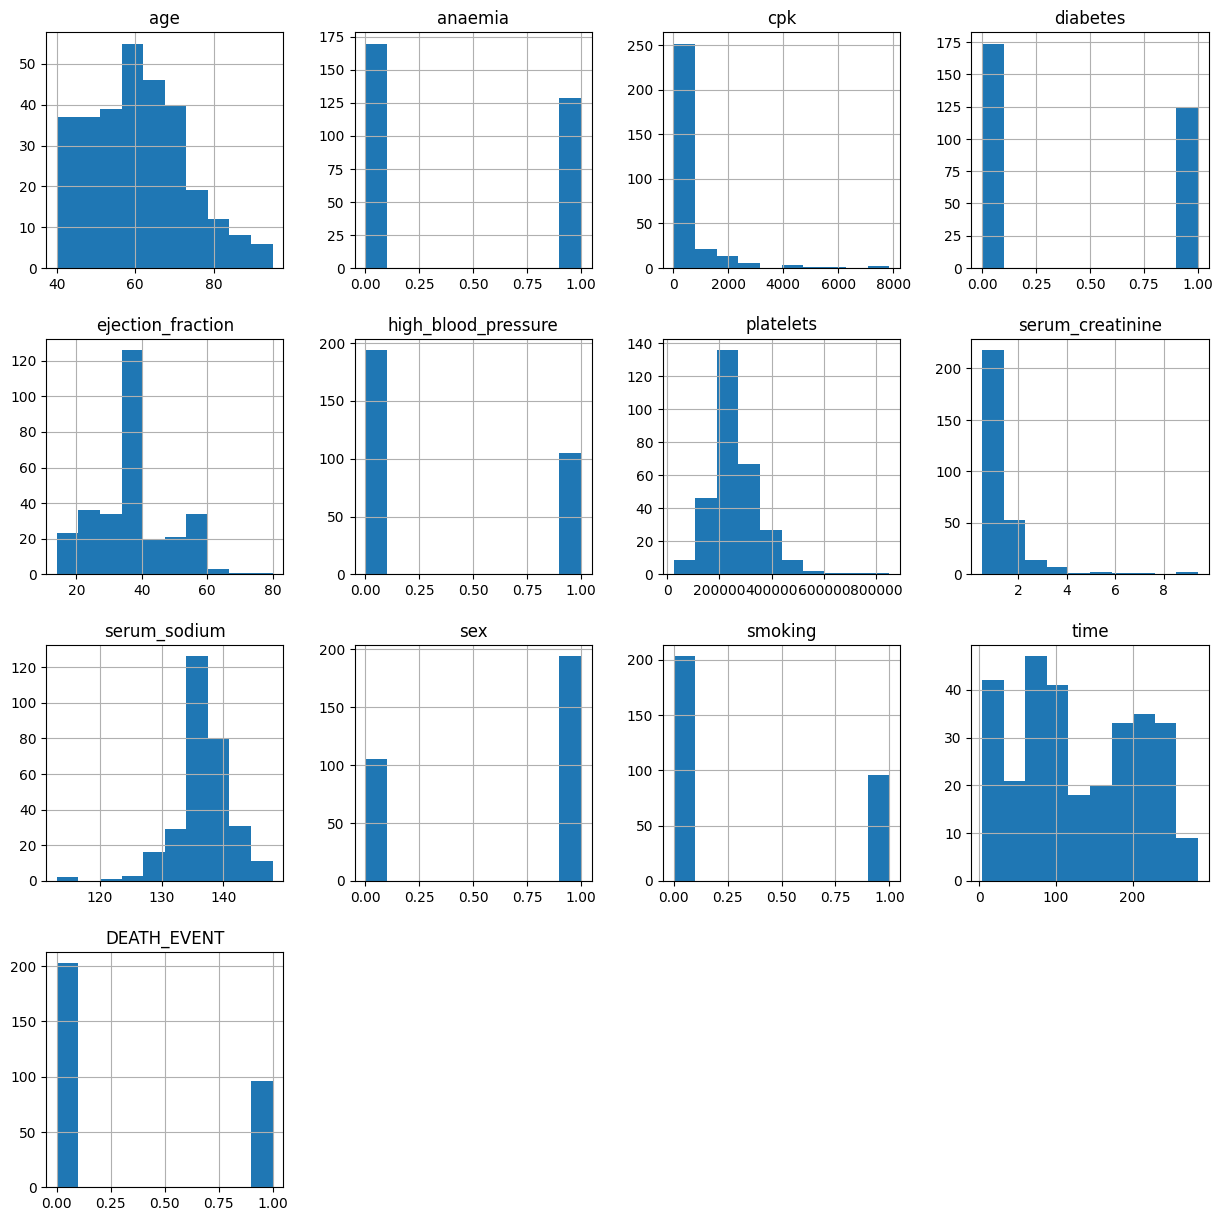

,age,anaemia,cpk,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [424]:
print("\nDATASET DESCRIPTION:")
display(df.describe())
print("\nDATASET BAR-GRAPH")
df.hist(figsize = [15,15])
plt.show()
df.describe()

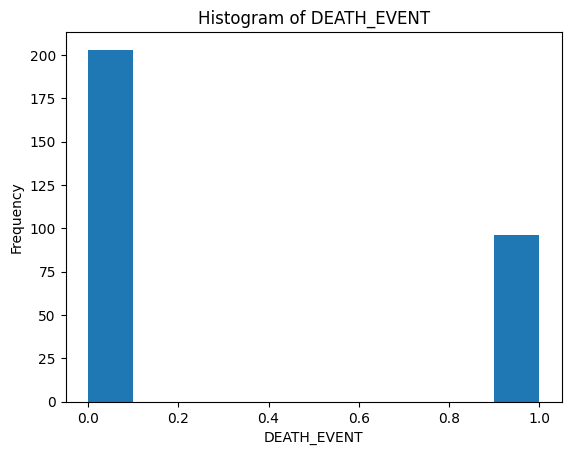

,age,anaemia,cpk,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [425]:
# Define the target variable
target = 'DEATH_EVENT'

# Plot histogram
plt.hist(df[target])
plt.title('Histogram of {}'.format(target))
plt.xlabel(target)
plt.ylabel('Frequency')

# Show the plot
plt.show()
df.describe()

## Integrity Check

The following code analyzes whether there are null or missing values in the dataset. In our case, it demonstrates that the dataset is complete and contains only relevant data.



In [426]:
display(df.columns)
np.sum(pd.isnull(df), 0)
df.describe()


Index(['age', 'anaemia', 'cpk', 'diabetes', 'ejection_fraction',
       'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium',
       'sex', 'smoking', 'time', 'DEATH_EVENT'],
      dtype='object')

,age,anaemia,cpk,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


## Data cleaning and classifing into dicrete interval
The pgmpy library primarily works with discrete parameters in the context of Bayesian networks. First we discretized, converted continuous variables into discrete categories, using a special technique, a variable-width binning, that allow to obtain intervals of different but meaningful sizes relative to the assessed domain. Our model assumes several binary variables and an equal number of continuous variables. The continuous variables (age, creatinine_phosphokinase, ejection_fraction, plateles, serum_creatinine,serum_sodium, time) have been discretized into intervals of variable width. 

To discretize the values in a DataFrame (`df`) into intervals we specified the dictionary `intervals`.

* The function `discretize`:
    - Iterate over each key-value pair in the `intervals` dictionary.
    - Use `pd.cut()` function to divide the values in the DataFrame column corresponding to the current feature into intervals specified by the corresponding value (list of boundaries).
    - Create a dictionary `interval` where the keys represent the intervals and the values represent the numerical representation of that interval (enumerated from 0 to the number of intervals).
    - Store the `interval` dictionary in the `data` dictionary with the key as the feature name.
    - Update the DataFrame column with the numerical representations of the intervals using `apply()` function.

* The values of the `data` dictionary and the updated version of `df` are printed



In [441]:
display(df.describe())
data = {}
intervals =   { 
            'age':[0.0,50.0,60.0,75.0,95.0], 
            'cpk':[0.0,200.0,350.0,550.0,3000.0,7861.0], 	
            'ejection_fraction': [0.0, 40.0, 50.0, 70.0, 100.0], 
            'platelets':[0.0, 150000.0, 400000.0, 850000.0],
            'serum_creatinine': [0.0, 0.48, 1.0, 1.5, 3.5, 9.5],
            'serum_sodium': [0.0, 110.0, 135.0, 145.0, 150.0],
            'time': [0.0, 70.0, 160.0, 300.0]
        }

display(df.describe())

def discretize():
    for key, val in intervals.items():
        bin = pd.cut(df[key], val)
        interval = {i: x for i, x in enumerate(bin.dtype.categories)}
        data[key] = interval
        display(bin.apply(lambda x: interval[x]))

discretize()

for col, map in data.items():
    print(col)
    table = tab(map.items(), headers=['Interval', 'Value'], tablefmt='fancy_grid')
    print(table, end='\n\n')

display(df.describe())


    

,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.00000
mean,0.431438,0.418060,0.351171,0.648829,0.32107,0.32107
std,0.496107,0.494067,0.478136,0.478136,0.46767,0.46767
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
50%,0.000000,0.000000,0.000000,1.000000,0.00000,0.00000
75%,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.00000
mean,0.431438,0.418060,0.351171,0.648829,0.32107,0.32107
std,0.496107,0.494067,0.478136,0.478136,0.46767,0.46767
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
50%,0.000000,0.000000,0.000000,1.000000,0.00000,0.00000
75%,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


KeyError: Interval(0.0, 50.0, closed='right')

* We have decided, for convenience, to represent for each node the labels of each interval and their corresponding values within the dataset.

In [ ]:
legenda_reverse = {
            'age': {'0-50': 0, 
                    '50-60': 1, 
                    '60-75': 2, 
                    '75-95': 3},
            'creatinine_phosphokinase': {'0-20': 0,
                                       '20-200': 1,
                                       '200-350': 2,
                                       '350-550': 3,
                                       '550-3000': 4,
                                       '3000-8000': 5},
            'ejection_fraction': {'0-40': 0, 
                                  '40-50': 1, 
                                  '50-70': 2, 
                                  '70-100': 3},
            'platelets': {'0-160000': 0, 
                          '160000-370000': 1, 
                          '370000-850000': 2},
            'serum_creatinine': {   '0-0.48': 0,
                                    '0.48-1.0': 1,
                                    '1.0-1.5': 2,
                                    '1.5-3.5': 3,
                                    '3.5-9.5': 4},
            'serum_sodium': {'110-135': 0, 
                             '135-145': 1, 
                             '145-150': 2},
            'time': {'0-70': 0, 
                     '70-160': 1, 
                     '160-300': 2},
            'DEATH_EVENT': {'Alive': 0, 
                            'Dead': 1},
            'anaemia': {'No': 0, 
                        'Yes': 1},
            'diabetes': {'No': 0, 
                         'Yes': 1},
            'high_blood_pressure': {'No': 0, 
                                    'Yes': 1},
            'sex': {'Female': 0, 
                    'Male': 1},
            'smoking': {'No': 0, 
                        'Yes': 1}
            }


## Network Modeling
The Bayesian model was derived from a thorough analysis of the data and their interactions. Information was obtained by reviewing various online research sources, and the validity of the network was assessed by a medical student. The student evaluated the consistency of the relationships between the nodes. 

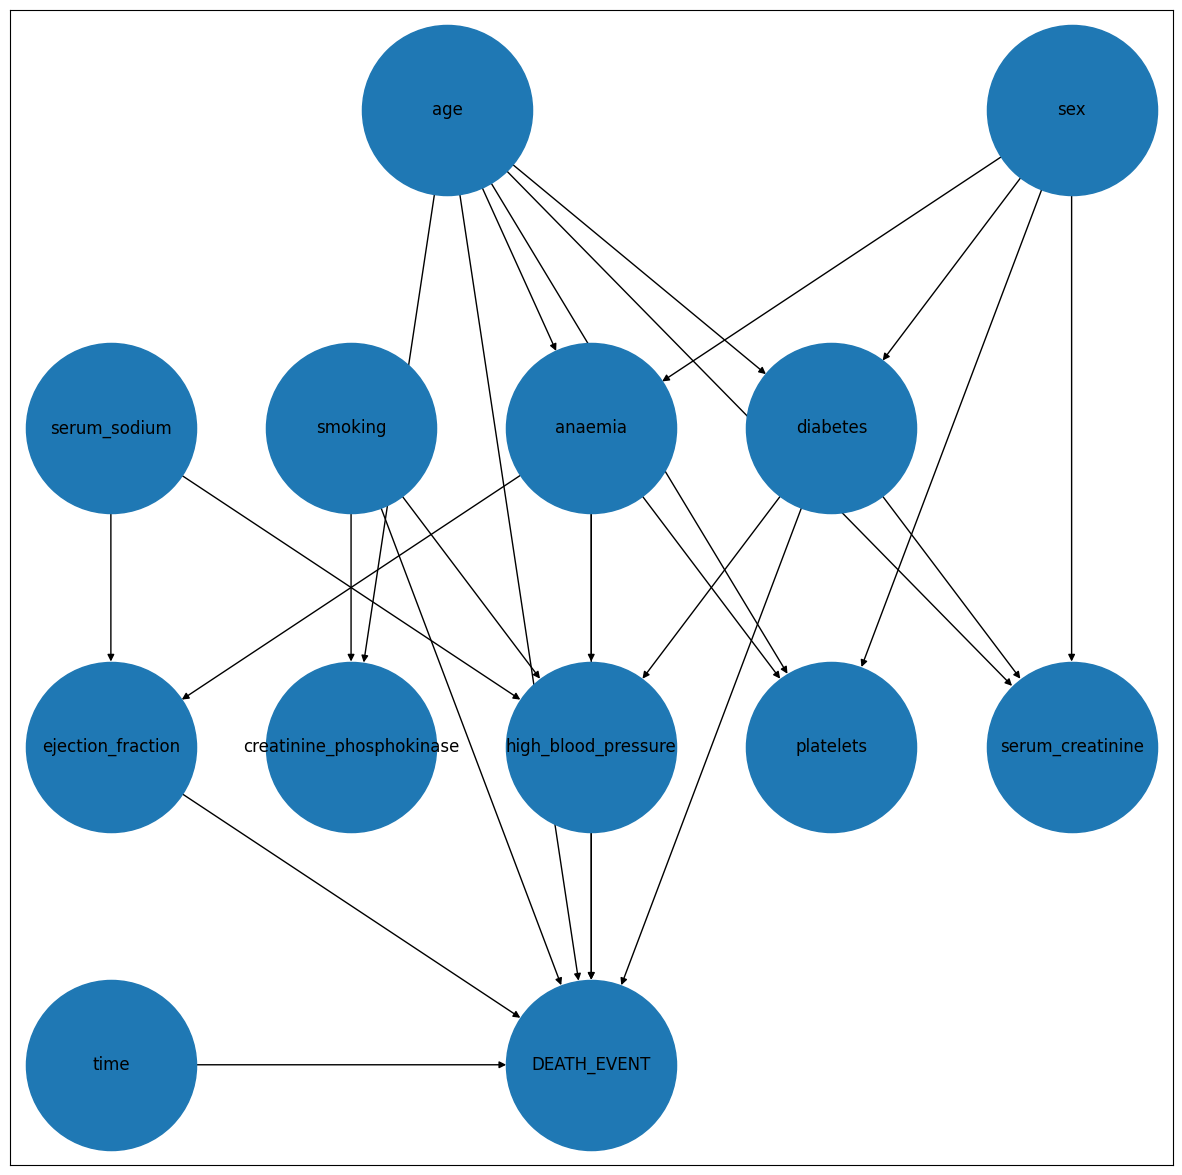

In [ ]:
network = BayesianNetwork([
                    ('age','anaemia'), 
                    ('age', 'creatinine_phosphokinase'),
                    ('age', 'diabetes'),
                    ('age', 'platelets'),
                    ('age', 'serum_creatinine'),
                    ('age', 'DEATH_EVENT'),
                    ('sex','anaemia'),
                    ('sex', 'diabetes'),
                    ('sex', 'platelets'),
                    ('sex', 'serum_creatinine'),
                    ('anaemia', 'ejection_fraction'),
                    ('anaemia', 'high_blood_pressure'),
                    ('anaemia', 'platelets'),
                    ('anaemia', 'DEATH_EVENT'),
                    ('diabetes', 'high_blood_pressure'),
                    ('diabetes', 'serum_creatinine'),
                    ('diabetes', 'DEATH_EVENT'),
                    ('smoking', 'high_blood_pressure'),
                    ('smoking', 'creatinine_phosphokinase'),
                    ('smoking', 'DEATH_EVENT'),
                    ('serum_sodium', 'high_blood_pressure'),
                    ('serum_sodium', 'ejection_fraction'),
                    ('ejection_fraction', 'DEATH_EVENT'),
                    ('high_blood_pressure', 'DEATH_EVENT'),
                    ('time', 'DEATH_EVENT')
                    ])

pos={
    'age':[0.60, -0.5], 'sex':[1.25, -0.5],
    'serum_sodium':[0.25, -1], 'smoking':[0.50, -1], 'anaemia':[0.75, -1], 'diabetes':[1, -1],
    'ejection_fraction':[0.25, -1.5], 'creatinine_phosphokinase':[0.50, -1.5], 'high_blood_pressure':[0.75, -1.5], 'platelets':[1, -1.5], 'serum_creatinine':[1.25, -1.5],
    'time':[0.25,-2], 'DEATH_EVENT':[0.75, -2]
    }

fig,ax = plt.subplots(1, 1, figsize=(15,15))
nx.draw_networkx(network, pos=pos, ax=ax, node_size=15000)


* The given code constructs a decision tree. The utilization of 'Tree Search' aids in identifying the most crucial or significant features within the dataset. The tree-building algorithm seeks variables that contribute the most to class separation or target variable prediction. Decision trees autonomously manage the selection of the most informative variables and their interactions, eliminating the necessity for manual input.

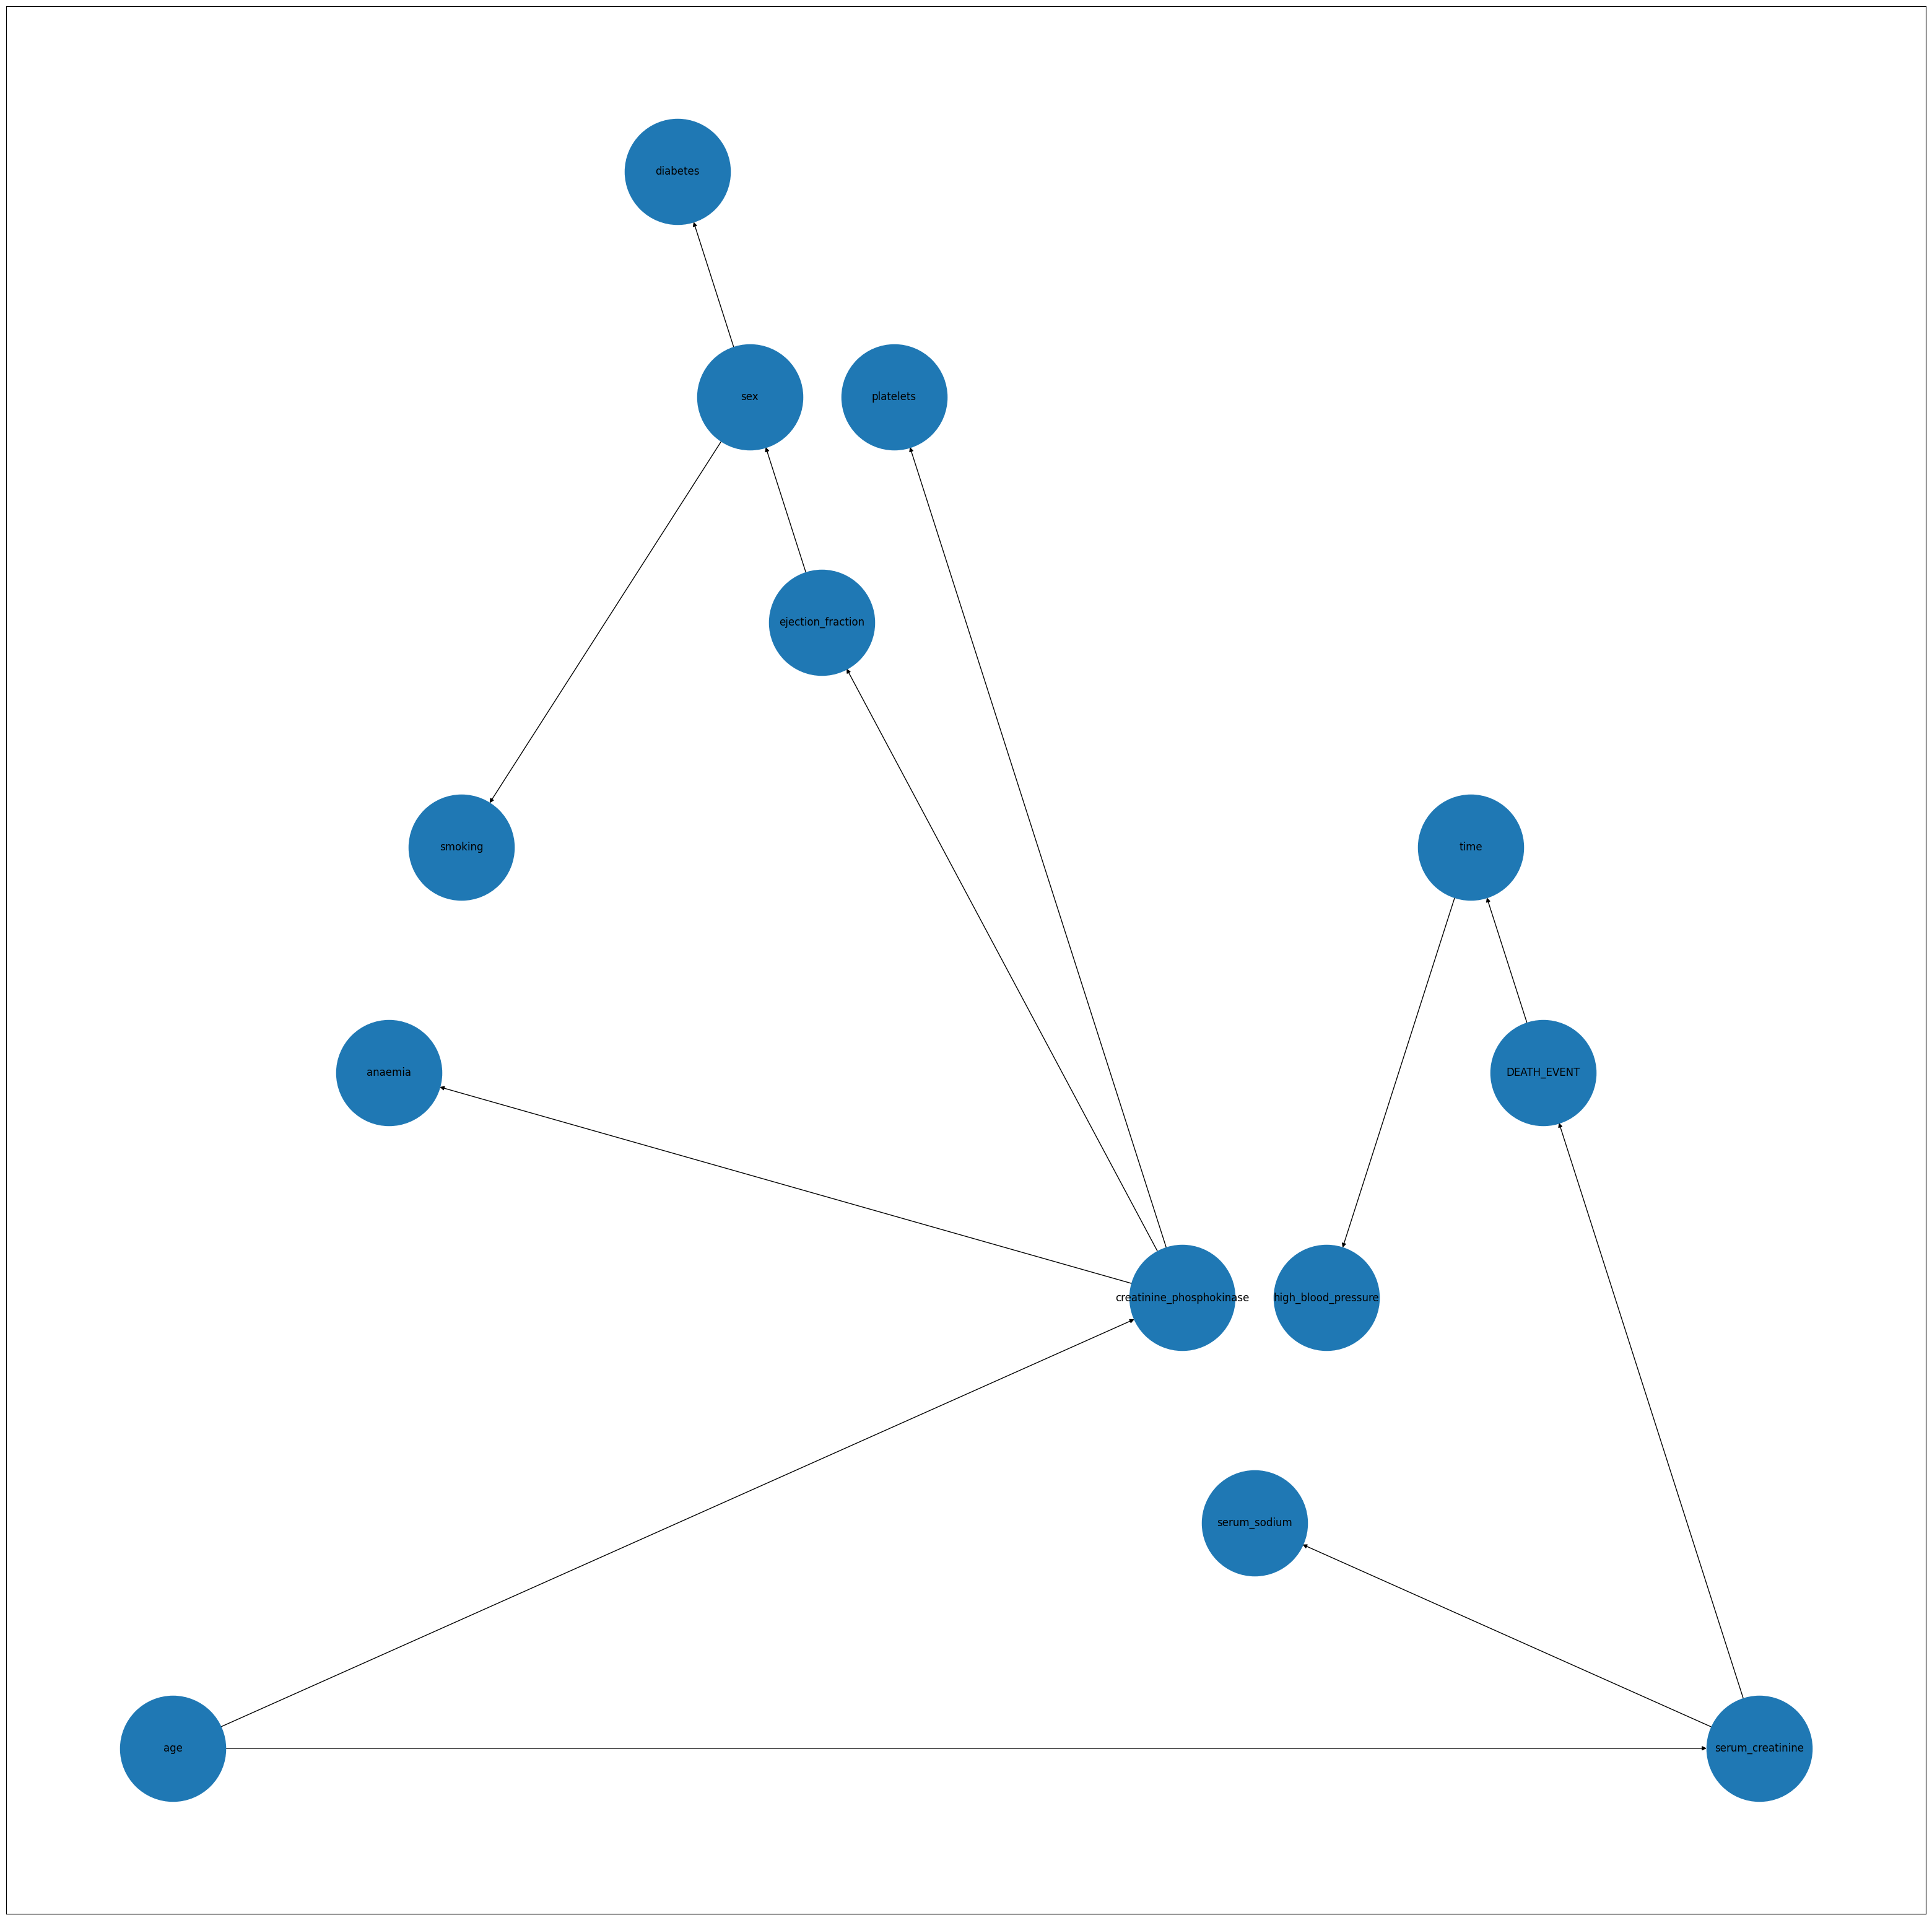

In [ ]:
ts = TreeSearch(data=df, root_node='age')
tree_model = ts.estimate(show_progress=False)

fig,ax = plt.subplots(1, 1, figsize=(40,40))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.planar_layout(tree_model), ax=ax, node_size=15000)

The Probabilistic Graphical Models in Python defined as pgmpy library has a particular emphasis on Bayesian networks. In this case of study this library implement the network and provides methods for probabilistic inference, performing queries on the Bayesian network. The primary methods used in this case is the MaximumLikelihoodEstimator to estimate the parameters from the provided data and the Bayesian Estimator. The Conditional Probability Tables (CPTs) are calculated using a Maximum Likelihood Estimator approach and a Bayesian Estimator, so that they could be inserted and adapted to the constructed Bayesian model. The developed code encompasses all the conditional probability tables for the various items.

   - MLE does not take into account any prior knowledge or assumptions about the distribution of the data. It simply finds the parameter values that maximize the likelihood of observing the data.
   - The Bayesian Estimator provides a posterior distribution of the parameters, which combines information from the observed data and the prior distribution.

In [ ]:
mle = MaximumLikelihoodEstimator(network, data=df)
be = BayesianEstimator(network, data=df)
for x in df.columns:
    print(x)
    print("Maximum Likelihood Estimator\n", mle.estimate_cpd(x))
    print("Bayesian Estimator\n", be.estimate_cpd(x))

age
Maximum Likelihood Estimator
 +--------+----------+
| age(0) | 0.247492 |
+--------+----------+
| age(1) | 0.294314 |
+--------+----------+
| age(2) | 0.35786  |
+--------+----------+
| age(3) | 0.100334 |
+--------+----------+
Bayesian Estimator
 +--------+----------+
| age(0) | 0.247533 |
+--------+----------+
| age(1) | 0.293586 |
+--------+----------+
| age(2) | 0.356086 |
+--------+----------+
| age(3) | 0.102796 |
+--------+----------+
anaemia
Maximum Likelihood Estimator
 +------------+---------------------+-----+--------------------+--------+
| age        | age(0)              | ... | age(3)             | age(3) |
+------------+---------------------+-----+--------------------+--------+
| sex        | sex(0)              | ... | sex(0)             | sex(1) |
+------------+---------------------+-----+--------------------+--------+
| anaemia(0) | 0.5483870967741935  | ... | 0.3333333333333333 | 0.5    |
+------------+---------------------+-----+--------------------+--------+
|

This code snippet is aimed at fitting a Bayesian network using observed data (`df`) by estimating the parameters of the conditional probability distributions (`CPDs`) for each node in the network. This process allows the Bayesian network to capture the conditional dependencies between variables based on the observed data.

In [ ]:
network.fit(data=df, estimator=MaximumLikelihoodEstimator) 


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be chang

### BIC (Bayesian Information Criterion) and K2 Score

The **BIC (Bayesian Information Criterion)** and the **K2 score** are two commonly used criteria for evaluating Bayesian network (BN) models in terms of how well they represent observed data, while accounting for the complexity of the model. Both criteria aim to balance the model's accuracy with its complexity to avoid overfitting.

1. **BIC (Bayesian Information Criterion)**: The BIC is a model selection criterion that penalizes model complexity more heavily than other criteria such as the AIC (Akaike Information Criterion). It is defined as:

   ```
   BIC = -2 * log-likelihood + k * log(n)
   ```

   Where:
   - `log-likelihood` is the logarithm of the likelihood of the model given the observed data.
   - `k` is the number of free parameters in the model.
   - `n` is the number of samples in the dataset.


2. **K2 Score**: The K2 score is another metric used to evaluate Bayesian network models. It is based on the idea that, due to the orientation of arrows in the Bayesian network graph, the structure of the network can be considered as a topological ordering. The K2 score seeks to maximize the likelihood of the model under the assumption that variables are appropriately ordered, i.e., the score is based on the formula:

   ```
   K2 = Π_{i=1}^{n} P(X_i | Pa(X_i))
   ```

   Where:
   - `X_i` is the variable we are trying to model.
   - `Pa(X_i)` are the parents of `X_i` in the Bayesian network graph.



In [ ]:
bic = BicScore(df)
k2 = K2Score(df)

display(k2.score(network))
display(bic.score(network))
display(k2.score(tree_model))
display(bic.score(tree_model))

-3375.98946567894

-5678.367346832254

-3176.638383001102

-3252.050138656202

## Noisy-OR 
In the implemented code, a symbolic and greedy approach to the "noisy OR" function is provided. The strategy involves creating probability tables for a specific node or event based on the occurrences of parent nodes. However, it's crucial to highlight that the probabilities associated with these parent nodes have been randomly generated.

In [ ]:
#considera i genitori e determina una funzione di noisy or con probabilità randomiche normalizzate per il verificarsi dell'evento target

def tabular_values(parents_card, target_card):
    res = [[] for i in range(np.prod(target_card))]
    columns = np.prod(parents_card)    
    ma = [1 for _ in range(columns)]

    for j in range(columns):
        for i in range(target_card):
            ma[j] = ma[j] - res[i-1][j] if i > 0 else 1
            if i == target_card-1:
                res[i].append(ma[j])
            else:
                res[i].append(random.uniform(0, ma[j]))
    return res

from functools import reduce
def generate_products(lists):
    combinations = product(*lists)
    products = [reduce(lambda x, y: x * y, combination) for combination in combinations]
    return products

def noisyOr_tabular_estimator(parents: list, target : str, network=network, variable_card=None):

    if variable_card is None:
        
        variable_card = network.get_cardinality(target)
    
    #values = [list(np.mean(network.get_cpds(node).get_values(), axis=1)) for node in parents]

    parents_card = [network.get_cardinality(node) for node in parents]

    res = tabular_values(parents_card, variable_card)


    tabular = TabularCPD(target, variable_card, res, parents, parents_card)
    return tabular

# Creiamo la tabella di Noisy OR per il nodo 'diabetes' stima tabella high blood pressure dando probabilità randomiche che si verifichino 
#diabete smoking e anemia, che non si verifichi e che si verifichi, opposte. 
cpd_diabetes_noisy_or = noisyOr_tabular_estimator(['diabetes', 'smoking', 'anaemia'], 'high_blood_pressure')

# Stampa la tabella di Noisy OR per il nodo 'diabetes'
print(cpd_diabetes_noisy_or)
print(network.get_cpds('high_blood_pressure'))


+------------------------+-----+--------------------+
| diabetes               | ... | diabetes(1)        |
+------------------------+-----+--------------------+
| smoking                | ... | smoking(1)         |
+------------------------+-----+--------------------+
| anaemia                | ... | anaemia(1)         |
+------------------------+-----+--------------------+
| high_blood_pressure(0) | ... | 0.2752760069841578 |
+------------------------+-----+--------------------+
| high_blood_pressure(1) | ... | 0.7247239930158422 |
+------------------------+-----+--------------------+
+------------------------+-----+-----------------+
| anaemia                | ... | anaemia(1)      |
+------------------------+-----+-----------------+
| diabetes               | ... | diabetes(1)     |
+------------------------+-----+-----------------+
| serum_sodium           | ... | serum_sodium(2) |
+------------------------+-----+-----------------+
| smoking                | ... | smoking(1)      

## Independences 
Bayesian networks enable modeling and analysis of probabilistic dependencies and independencies between variables. Permit to identify relevant variables for a given phenomenon.

In [ ]:
print("Total number of valid indipendencies: ", len(network.get_independencies().get_assertions()))
for node in network.nodes():
    print("Local independencies: ", network.local_independencies(node))

Total number of valid indipendencies:  26133
Local independencies:  (age ⟂ sex, serum_sodium, smoking, time)
Local independencies:  (anaemia ⟂ serum_creatinine, smoking, time, creatinine_phosphokinase, diabetes, serum_sodium | sex, age)
Local independencies:  (creatinine_phosphokinase ⟂ serum_creatinine, time, platelets, DEATH_EVENT, anaemia, diabetes, ejection_fraction, sex, serum_sodium, high_blood_pressure | age, smoking)
Local independencies:  (diabetes ⟂ ejection_fraction, smoking, time, platelets, creatinine_phosphokinase, anaemia, serum_sodium | sex, age)
Local independencies:  (platelets ⟂ serum_creatinine, smoking, time, DEATH_EVENT, diabetes, ejection_fraction, creatinine_phosphokinase, serum_sodium, high_blood_pressure | sex, age, anaemia)
Local independencies:  (serum_creatinine ⟂ smoking, time, platelets, DEATH_EVENT, anaemia, ejection_fraction, creatinine_phosphokinase, serum_sodium, high_blood_pressure | sex, age, diabetes)
Local independencies:  (DEATH_EVENT ⟂ serum_cre

# Performing inference

The function below is used to combine all possible values of the variables into a single dataframe

In [ ]:
#combinazioni di tutti i possibili valori assunti per ogni nodo su cui puoi fare inferenza, se ho age con 4 valori e sesso 2 mi da tutte le conbinazioni di eta e di sesso 
def cartesian_product(evidences):

    # Remove Given Evidence
    given = {key: value for key, value in evidences.items() if value is not None}
    combine = {key: value for key, value in evidences.items() if value is None}

    # Get values for each specified key
    values = [list(legenda_reverse[key]) for key in combine]
    # Calculate all combinations of values across specified keys
    combinations = list(product(*values))

    # Pairing keys with values
    combinations = [{key: value for key, value in zip(combine.keys(), combination)} for combination in combinations ]
    for combination in combinations:
        combination.update(given)

    # append given evidence to each combination
    return combinations

The function below is used to calculate the probability of a given query variable value given an evidence variable value. The implementation of the inference function takes different arguments:
* evidences: A dictionary containing the evidence (known values) for some variables in the Bayesian network.
* target: The target variable for which inference is to be performed.
* network: The Bayesian network model on which inference is to be carried out.

The function returns the probability of the query variable value given the evidence variable value

In [ ]:
#per chiamare inferenza 
def inference(evidences : dict, target : str, network=network, combinations=None):
    inferences = VariableElimination(network)
    res = {}
    
    if combinations is None:
        combinations = cartesian_product(evidences)
   
    for comb in combinations:
        evidence = {key: legenda_reverse[key][value] for key, value in comb.items()}

        q = inferences.query(variables=[target], evidence=evidence)
        res[','.join(comb.values())] = q.values
        
    return res

The function below is used to graph the probabilities of the variables using a bar plot.

In [ ]:
legenda = {key: {v: k for k, v in val.items()} for key, val in legenda_reverse.items()}


def plot_bar(data, title, evidences, target, fig_size=(50, 5)):
    dataFrame = pd.DataFrame([[str(x), legenda[target][bars], float(y)]
                 for x in data.keys()
                 for bars, y in enumerate(data[x])],
                 columns=[str(evidences), str(target), 'Probability'])

    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    sns.barplot(x=str(evidences), y='Probability', hue=str(target), data=dataFrame, ax=ax, palette='dark')
    plt.title(title)
    plt.show()

### Probability of serum creatinine of a female influenced by age and serum sodium

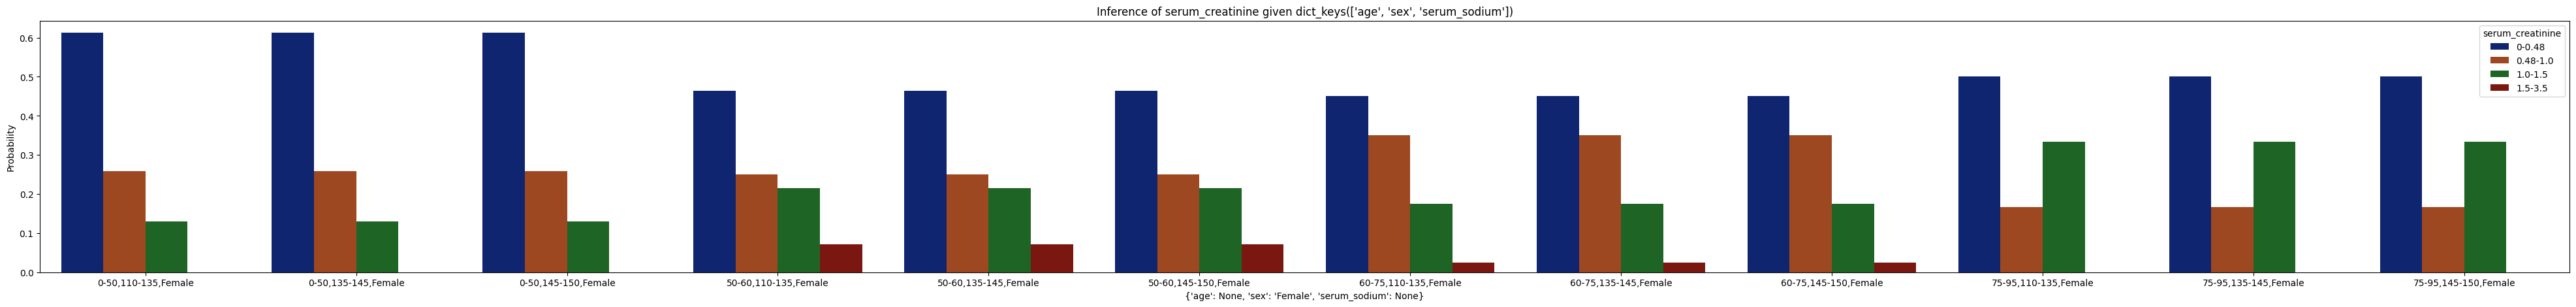

In [ ]:
evidences = {'age':None, 'sex':'Female', 'serum_sodium':None }
title = "Inference of serum_creatinine given {}".format(evidences.keys())

inf  = inference(evidences, 'serum_creatinine', network)
plot_bar(inf, title, evidences, 'serum_creatinine')

### How smoking affects death in a young person?

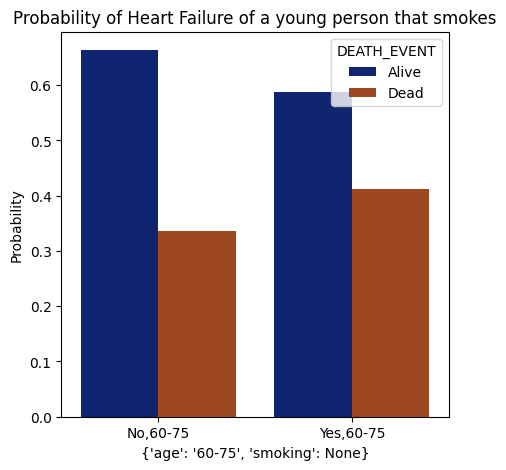

In [ ]:
title='Probability of Heart Failure of a young person that smokes'
evidence = {'age': '60-75' , 'smoking': None}
target = 'DEATH_EVENT'

inf = inference(evidence, target, network)
plot_bar(inf, title, evidence, target, fig_size=(5, 5))


### How high blood pressure, often actively influenced by diseases such as anemia and diabetes, can be brought within correct parameters with appropriate sodium levels?

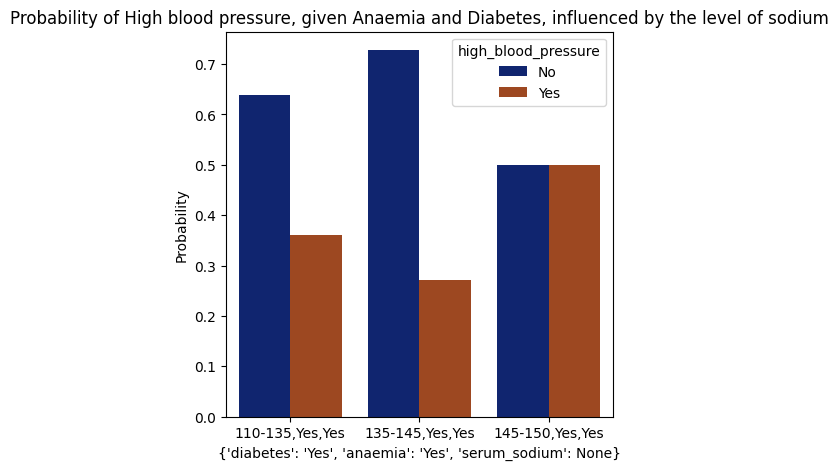

In [ ]:
#per prevenire il richio di morte determinata diabete e anemia conviene avere livelli di sodio alti o bassi 

title='Probability of High blood pressure, given Anaemia and Diabetes, influenced by the level of sodium'
evidence = {'diabetes': 'Yes' , 'anaemia': 'Yes', 'serum_sodium': None}
target = 'high_blood_pressure'

inf = inference(evidence, target, network)
plot_bar(inf, title, evidence, target, fig_size=(5, 5))

In [ ]:
print("Local independencies: ", network.local_independencies('anaemia'))

Local independencies:  (anaemia ⟂ serum_creatinine, smoking, time, creatinine_phosphokinase, diabetes, serum_sodium | sex, age)


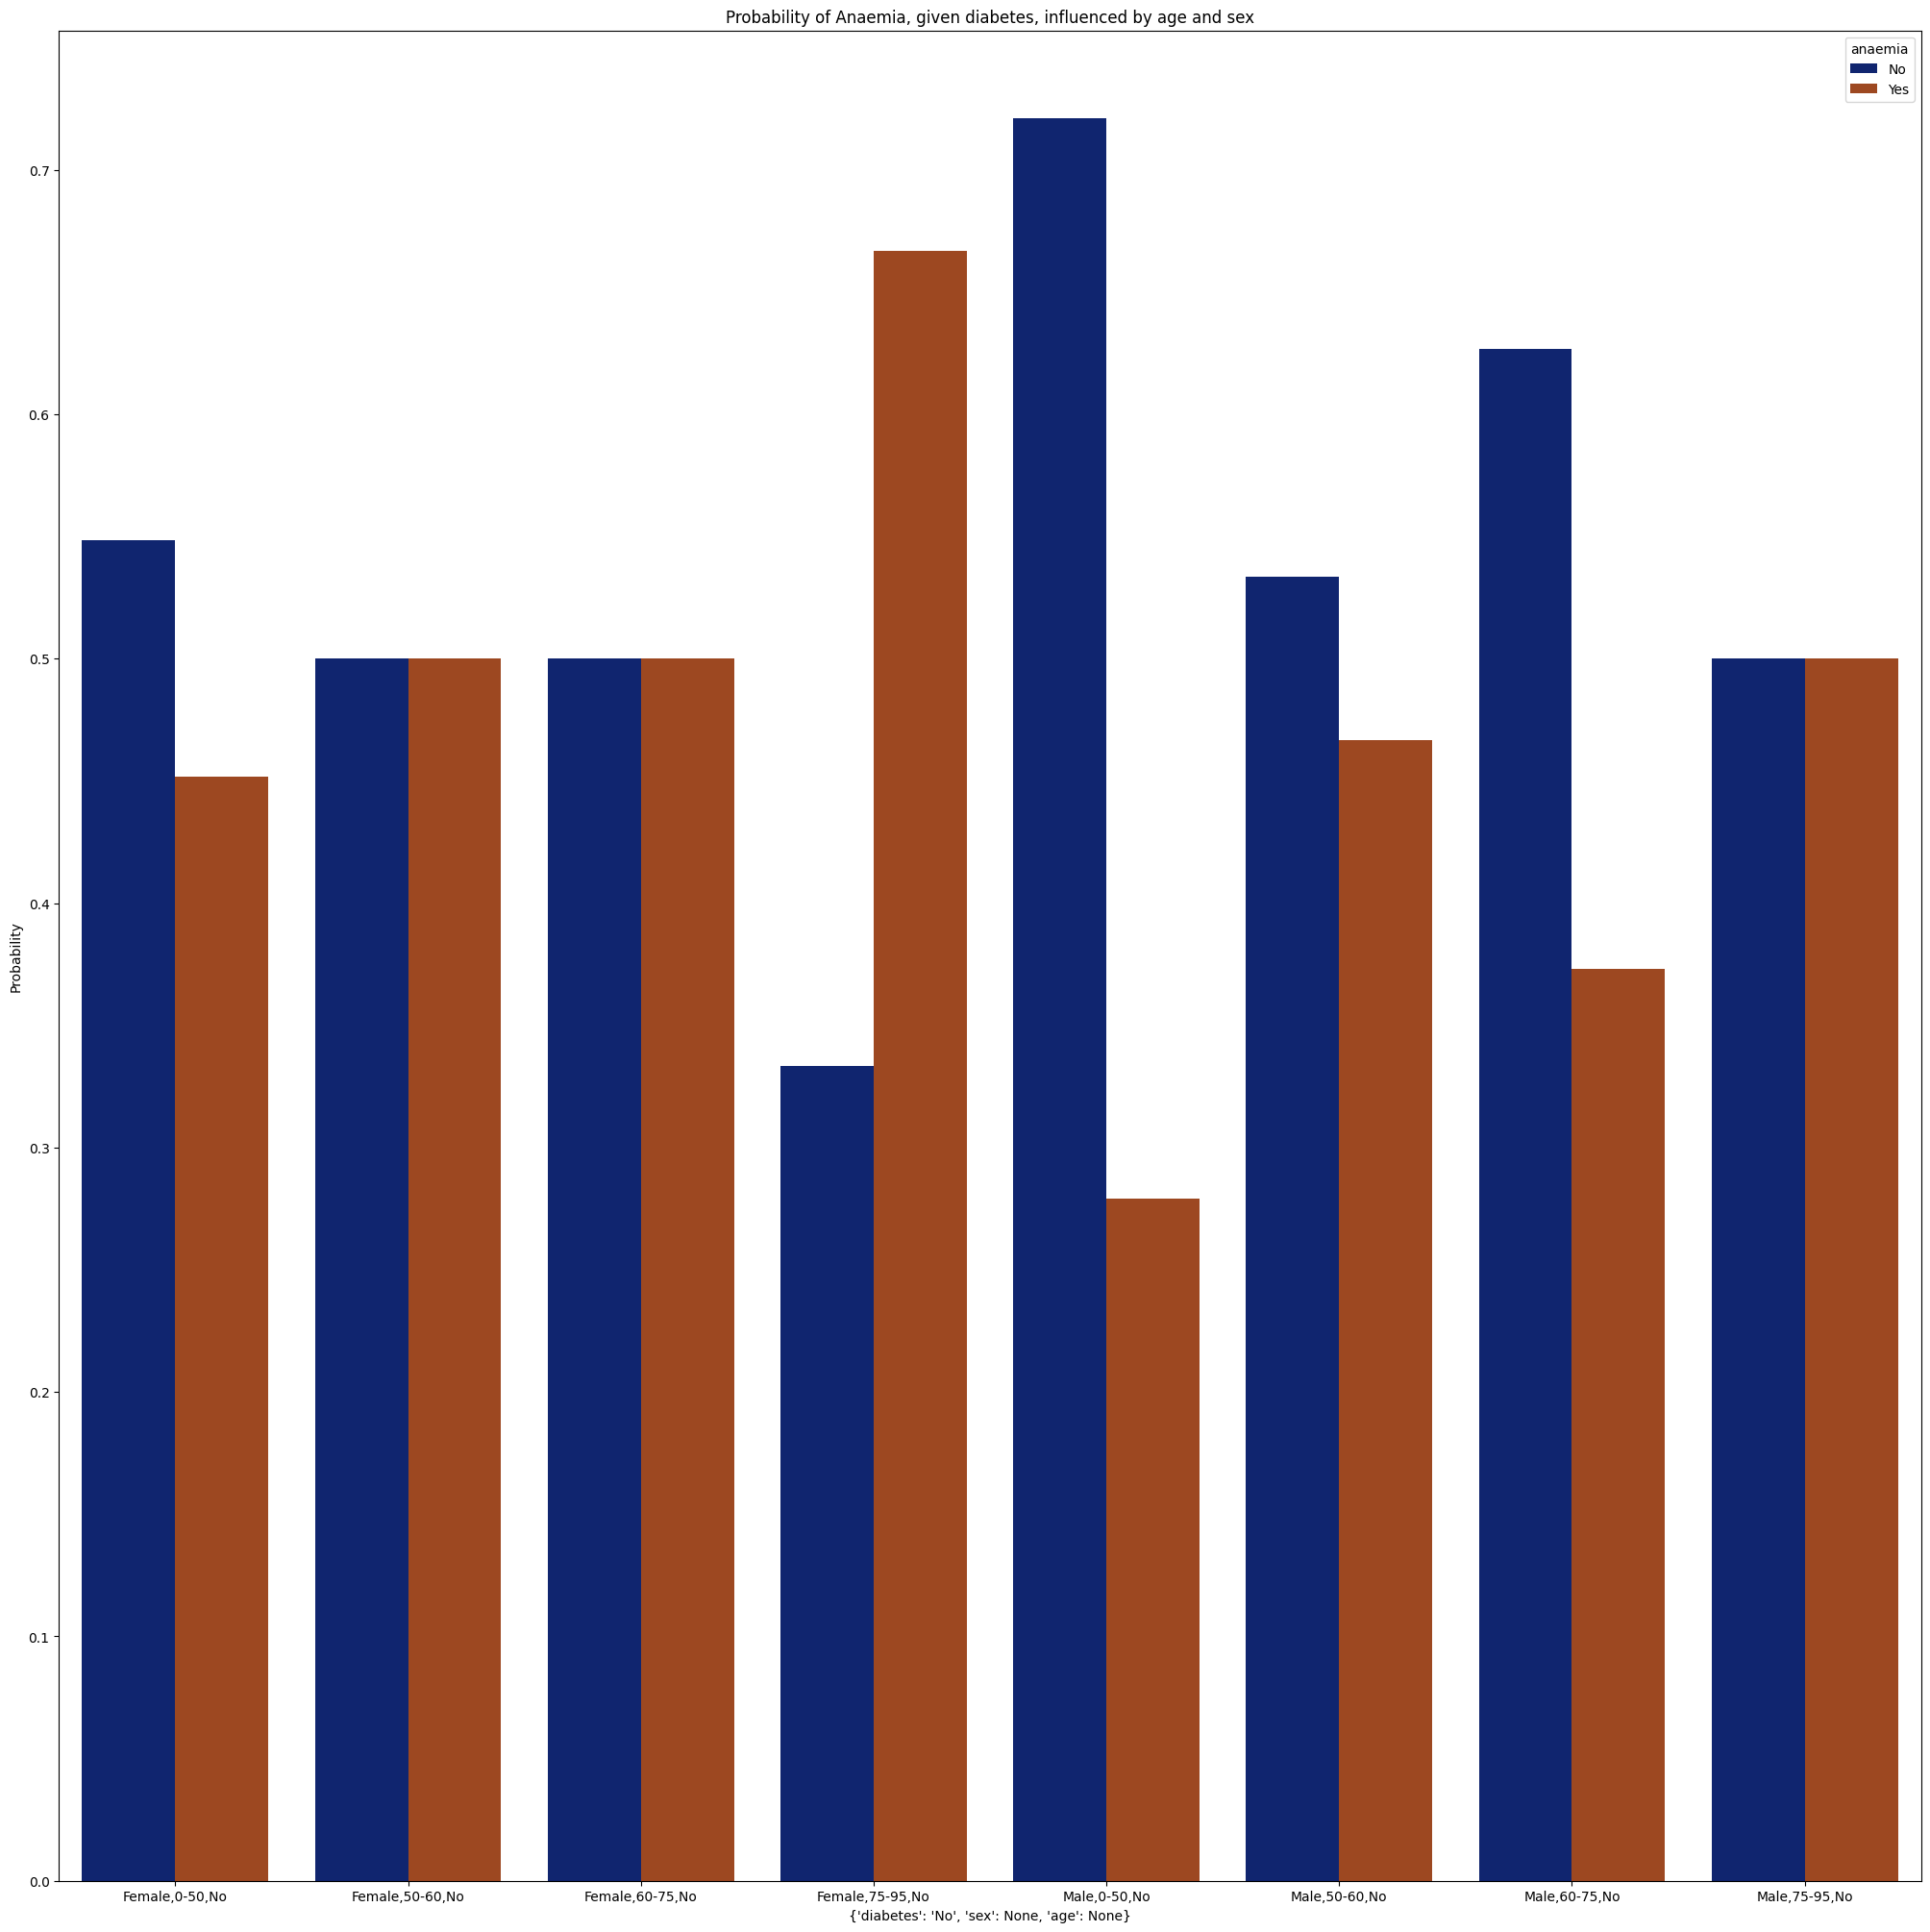

In [ ]:
title='Probability of Anaemia, given diabetes, influenced by age and sex'
evidence = {'diabetes':'No', 'sex': None, 'age': None}
target = 'anaemia'

inf = inference(evidence, target, network)
plot_bar(inf, title, evidence, target, fig_size=(25, 25))

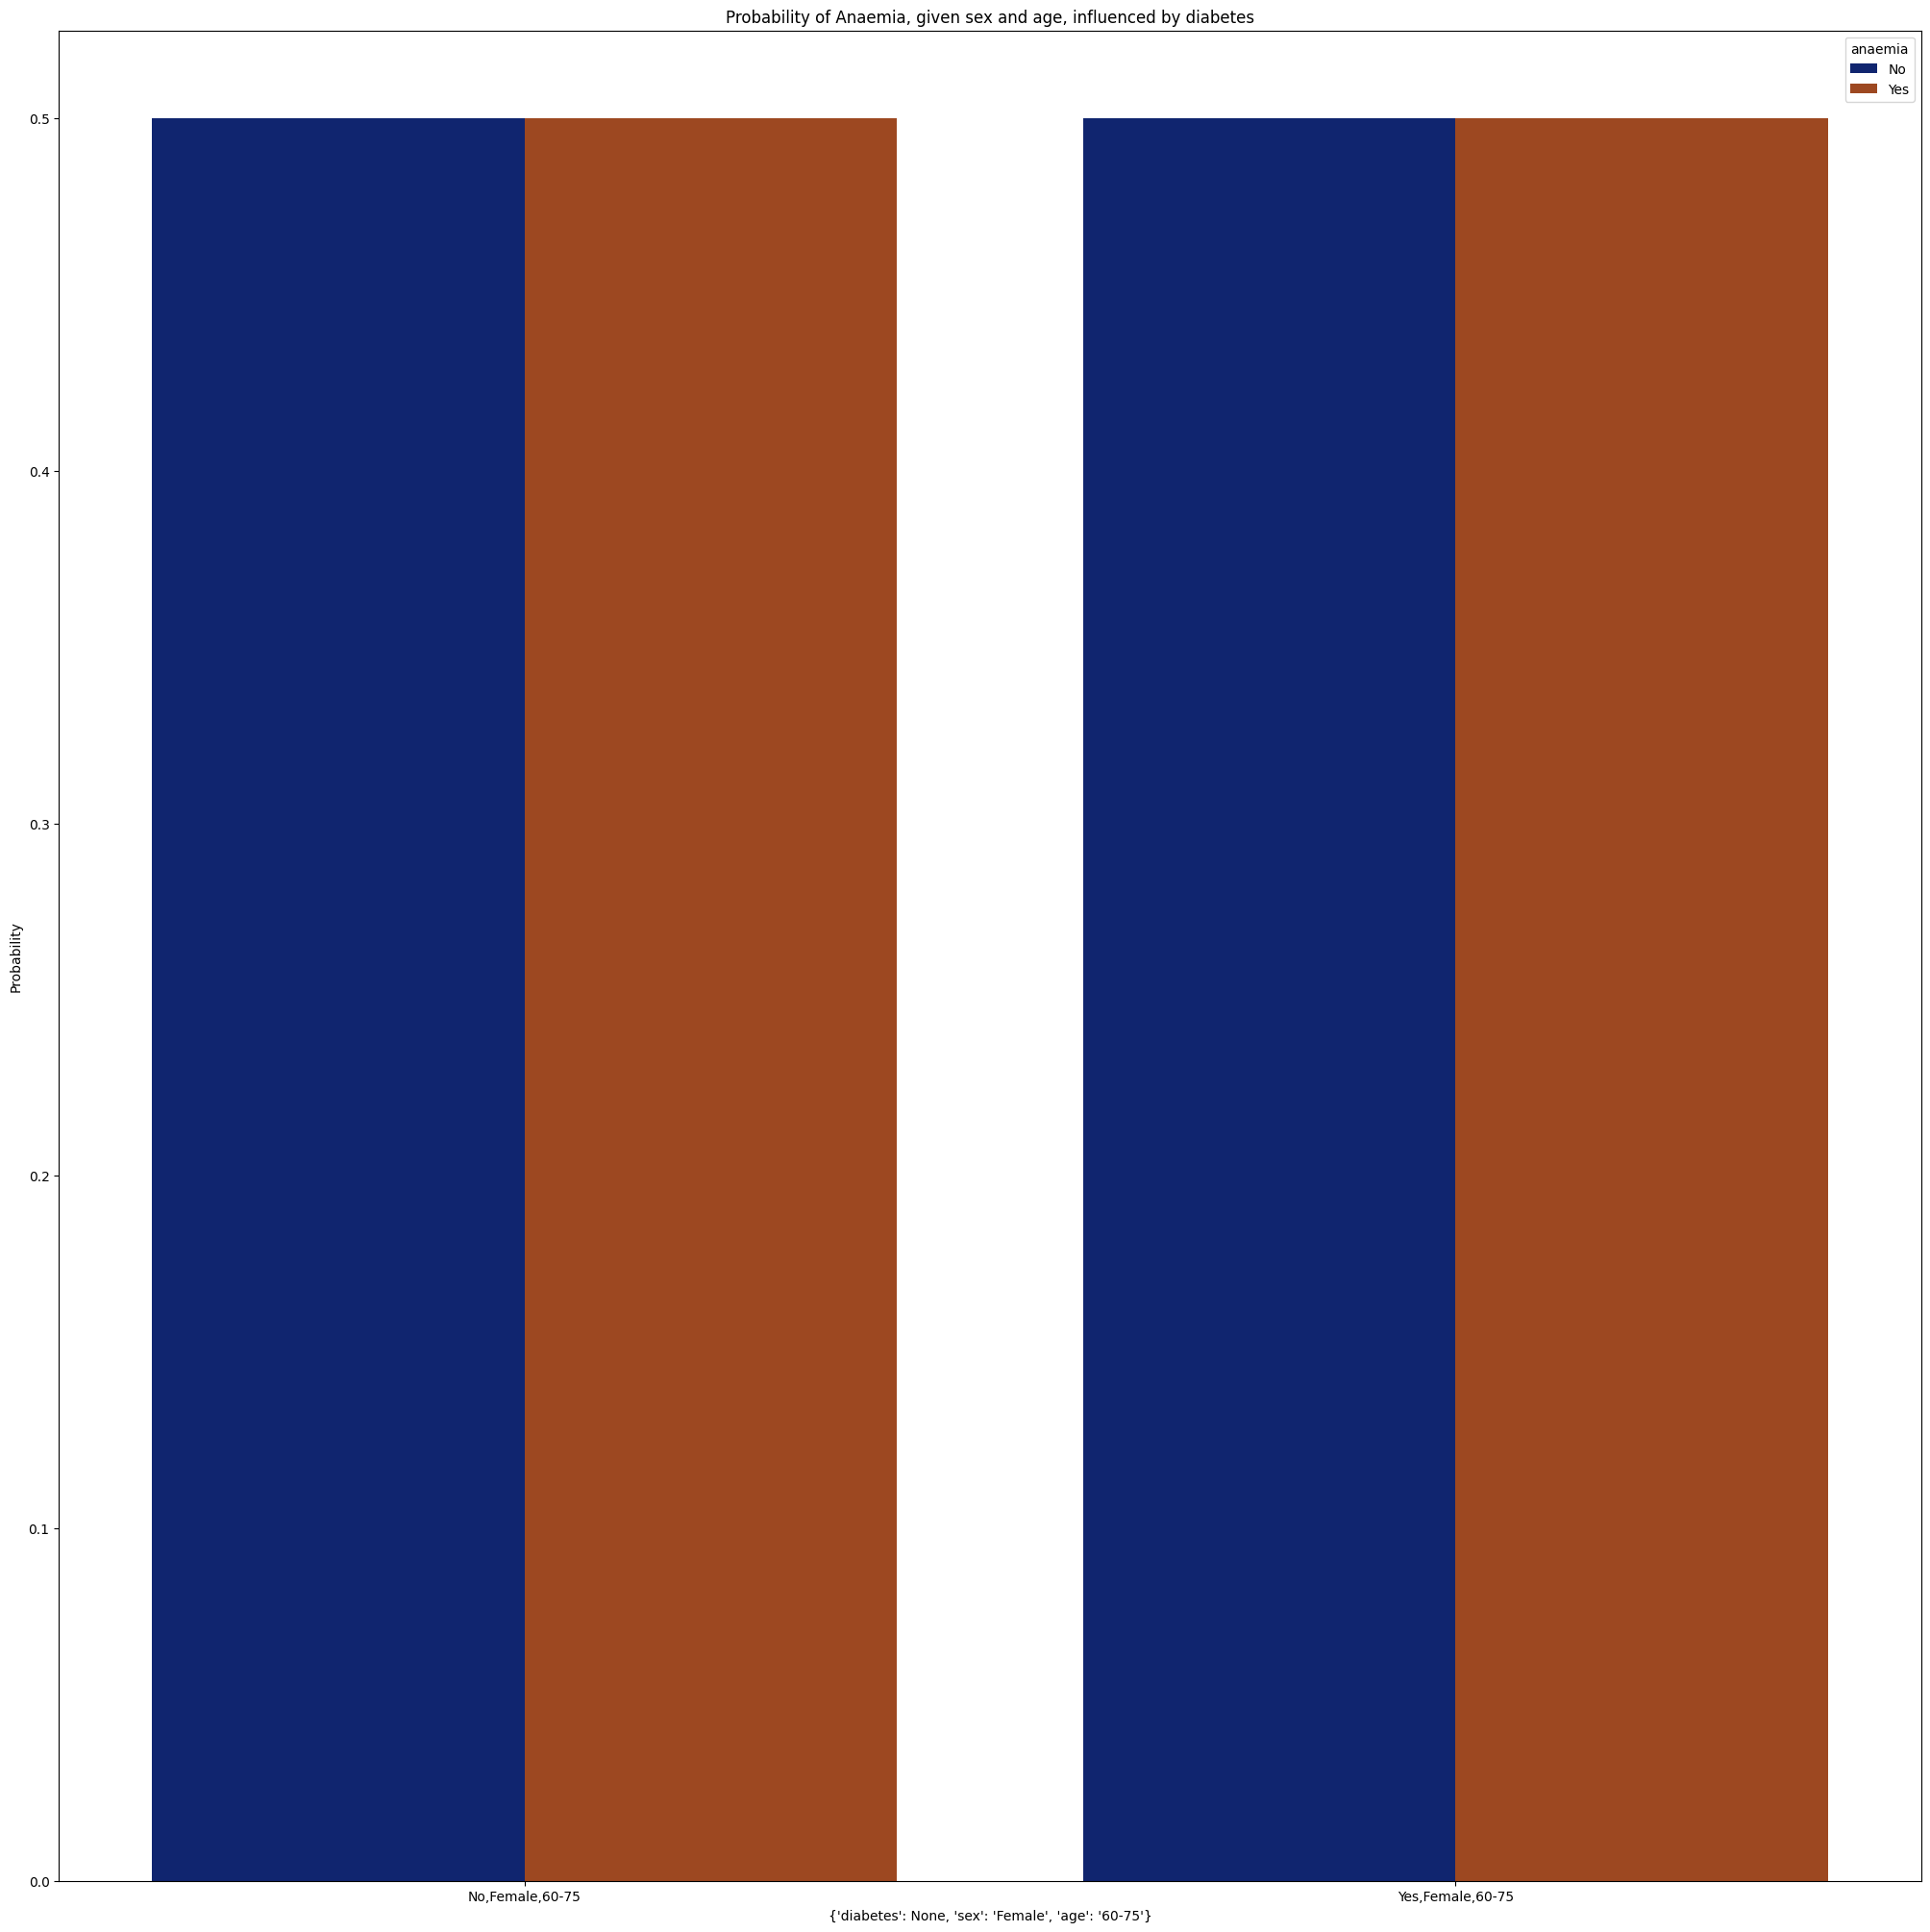

In [ ]:
title='Probability of Anaemia, given sex and age, influenced by diabetes'
evidence = {'diabetes':None, 'sex': 'Female', 'age': '60-75'}
target = 'anaemia'

inf = inference(evidence, target, network)
plot_bar(inf, title, evidence, target, fig_size=(25, 25))

## Markov Blanket 

In [ ]:
#markov_blanket = set(inference.markov_blanket('serum_creatinine'))
print('Checking Markov blankets')
for node in network.nodes():
    print(f'The Markov blanket of node {node} is {network.get_markov_blanket(node)}')
print()

Checking Markov blankets
The Markov blanket of node age is ['serum_creatinine', 'smoking', 'time', 'platelets', 'DEATH_EVENT', 'anaemia', 'diabetes', 'sex', 'ejection_fraction', 'creatinine_phosphokinase', 'high_blood_pressure']
The Markov blanket of node anaemia is ['smoking', 'time', 'platelets', 'DEATH_EVENT', 'diabetes', 'age', 'ejection_fraction', 'sex', 'serum_sodium', 'high_blood_pressure']
The Markov blanket of node creatinine_phosphokinase is ['age', 'smoking']
The Markov blanket of node diabetes is ['serum_creatinine', 'smoking', 'time', 'DEATH_EVENT', 'anaemia', 'age', 'ejection_fraction', 'sex', 'serum_sodium', 'high_blood_pressure']
The Markov blanket of node platelets is ['sex', 'age', 'anaemia']
The Markov blanket of node serum_creatinine is ['sex', 'age', 'diabetes']
The Markov blanket of node DEATH_EVENT is ['smoking', 'time', 'anaemia', 'diabetes', 'age', 'ejection_fraction', 'high_blood_pressure']
The Markov blanket of node sex is ['serum_creatinine', 'platelets', 'a

In [ ]:
markov_blanket = set(network.get_markov_blanket('serum_sodium'))
print(f"Feature rilevanti per il nodo '{'serum_sodium'}': {markov_blanket}")

Feature rilevanti per il nodo 'serum_sodium': {'smoking', 'anaemia', 'diabetes', 'ejection_fraction', 'high_blood_pressure'}


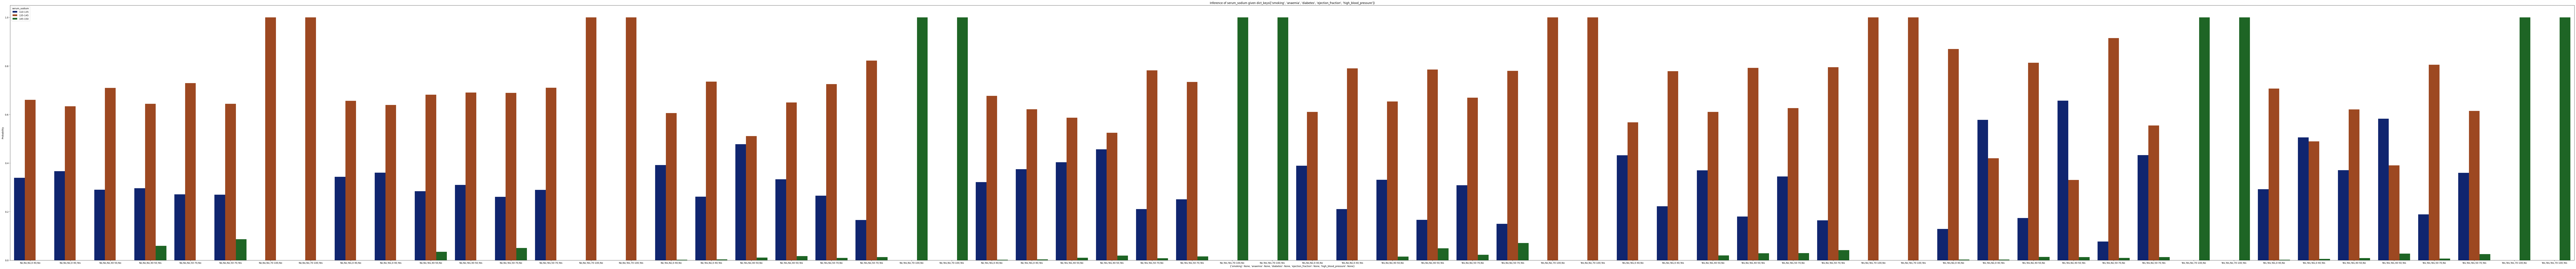

In [ ]:
evidences = {key: None for key in markov_blanket}

inf = inference(evidences, 'serum_sodium', network)
plot_bar(inf, 'Inference of serum_sodium given {}'.format(evidences.keys()), evidences, 'serum_sodium', fig_size=(200, 20))